In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
train = pd.read_pickle("/gdrive/My Drive/Data/train.pkl")
test = pd.read_pickle("/gdrive/My Drive/Data/test.pkl")
sample = pd.read_csv("/gdrive/My Drive/Data/sample_submission.csv")
df_train = pd.DataFrame(columns=['game_id'])
df_train.game_id = train.game_id.unique()
df_train['time'] = np.array(train[train.shift(-1).game_id != train.game_id].time)
df_train['winner'] = np.array(train[train.shift(-1).game_id != train.game_id].winner)
df_train["win_prop"] = 0.5

In [0]:
df = train[['game_id', 'winner', 'player', 'species']]
df = df.drop_duplicates().reset_index(drop=True)
df['win'] = (df['winner'] == df['player'])
df = df.drop(['winner'], axis=1)
game_ids = df['game_id'].unique()

wins  = df.loc[df['win']==True]
loses = df.loc[df['win']==False]

game = {'TvP':0, 'TvZ':0, 'PvT':0, 'PvZ':0, 'ZvT':0, 'ZvP':0,}

for game_id in game_ids:
    win  = wins[wins['game_id']==game_id]['species'].iloc[0]
    lose = loses[loses['game_id']==game_id]['species'].iloc[0]

    if (win == 'T') and (lose == 'P'):
        game['TvP'] += 1
    elif (win == 'T') and (lose == 'Z'):
        game['TvZ'] += 1
        
    elif (win == 'P') and (lose == 'T'):
        game['PvT'] += 1
    elif (win == 'P') and (lose == 'Z'):
        game['PvZ'] += 1
        
    elif (win == 'Z') and (lose == 'T'):
        game['ZvT'] += 1
    elif (win == 'Z') and (lose == 'P'):
        game['ZvP'] += 1
        
    else:
        pass

In [0]:
for game_id in tqdm(game_ids):
  game_id = int(game_id)
  player0_sp = df[df['game_id']==game_id]['species'].iloc[0]
  player1_sp = df[df['game_id']==game_id]['species'].iloc[1]
  if (player0_sp == player1_sp):
    continue
  elif (player0_sp == 'T') and (player1_sp == 'P'):
    df_train["win_prop"][game_id] = game['PvT']/(game['TvP']+game['PvT'])
  elif (player0_sp == 'T') and (player1_sp == 'Z'):
    df_train["win_prop"][game_id] = game['ZvT']/(game['TvZ']+game['ZvT'])
        
  elif (player0_sp == 'P') and (player1_sp == 'T'):
    df_train["win_prop"][game_id] = game['TvP']/(game['TvP']+game['PvT'])
  elif (player0_sp == 'P') and (player1_sp == 'Z'):
    df_train["win_prop"][game_id] = game['ZvP']/(game['PvZ']+game['ZvP'])
        
  elif (player0_sp == 'Z') and (player1_sp == 'T'):
    df_train["win_prop"][game_id] = game['TvZ']/(game['TvZ']+game['ZvT'])
  elif (player0_sp == 'Z') and (player1_sp == 'P'):
    df_train["win_prop"][game_id] = game['PvZ']/(game['PvZ']+game['ZvP'])


In [0]:
for event in tqdm(train.event.unique()):
    df = train[(train.player==0)&(train.event==event)]
    df["time_tmg"] = df["time"].astype(int)
    df = df.groupby(["time_tmg","game_id"]).count()["event"].unstack("time_tmg")
    df.columns = df.columns.astype(str)
    df.columns = event + df.columns + "_count_0"
    df_train = df_train.merge(df, on='game_id', how='left')

    df = train[(train.player==1)&(train.event==event)]
    df["time_tmg"] = df["time"].astype(int)
    df = df.groupby(["time_tmg","game_id"]).count()["event"].unstack("time_tmg")
    df.columns = df.columns.astype(str)
    df.columns = event + df.columns + "_count_1"
    df_train = df_train.merge(df, on='game_id', how='left')

    df_train = df_train.fillna(0)
    for i in range(11):
      # df_train[event+str(i)+'_count_0']+=1
      # df_train[event+str(i)+'_count_1']+=1
      df_train[event +str(i)+ '_diff'] = df_train[event+str(i)+'_count_0'] - df_train[event+str(i)+'_count_1']
      df_train.drop([event+str(i)+'_count_0',event+str(i)+'_count_1'],axis=1,inplace=True)

In [0]:
for event in train.event.unique():
    df = train[(train.player==0)&(train.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_0'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_train = pd.merge(df_train, df, on='game_id', how='left')

    df = train[(train.player==1)&(train.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_1'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_train = pd.merge(df_train, df, on='game_id', how='left')
    
df_train = df_train.fillna(0)
for event in train.event.unique():
    df_train[event + '_diff'] = df_train[event+'_count_0'] - df_train[event+'_count_1']
    df_train.drop([event+'_count_0',event+'_count_1'],axis=1,inplace=True)

In [197]:
df_train.head()

,game_id,time,winner,win_prop,Camera_diff,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff
0,0,7.24,1,0.500000,19.0,-7.0,0.0,7.0,2.0,21.0,2.0,0.0
1,1,9.59,1,0.501208,-231.0,70.0,10.0,29.0,2.0,131.0,1.0,0.0
2,2,9.59,0,0.487896,-312.0,-142.0,-16.0,-44.0,5.0,-10.0,1.0,-2.0
3,3,9.59,0,0.501208,325.0,32.0,-7.0,8.0,-13.0,-578.0,0.0,0.0
4,4,5.43,0,0.493500,158.0,-59.0,21.0,71.0,2.0,125.0,-3.0,0.0


In [0]:
train2 = train.dropna(axis=0)
# train2.head()

In [0]:
train2[train2["event"]=="Selection"].head(15)

,game_id,winner,time,player,species,event,event_contents
2,0,1,0.02,0,T,Selection,['OrbitalCommand [3080001]']
28,0,1,0.33,0,T,Selection,['OrbitalCommand [3080001]']
57,0,1,0.40,1,T,Selection,['OrbitalCommand [33C0001]']
68,0,1,0.47,0,T,Selection,['SCV [3280001]']
102,0,1,1.06,0,T,Selection,['CreepOnlyBlocker4x4 [1B00001]']
103,0,1,1.07,0,T,Selection,"['SCV [30C0001]', 'SCV [3780001]']"
110,0,1,1.15,0,T,Selection,['SCV [3380001]']
130,0,1,1.23,1,T,Selection,"['SCV [3400001]', 'SCV [3440001]', 'SCV [34C00..."
137,0,1,1.27,0,T,Selection,['SCV [3100001]']
141,0,1,1.30,1,T,Selection,"['SCV [3680001]', 'SCV [3840001]']"


In [0]:
def plot_camera(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']=='Camera']
    df_0 = df.loc[df['player']==0]
    df_1 = df.loc[df['player']==1]

    winner = df['winner'].iloc[0]
    game_time = df['time'].values[-1]
    player_0_species = df_0['species'].iloc[0]
    player_1_species = df_1['species'].iloc[0]

    player_0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_0['event_contents']]).astype(float).astype(int)
    player_1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_1['event_contents']]).astype(float).astype(int)
    
    plt.scatter(player_0_camera[:, 0], player_0_camera[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    plt.scatter(player_1_camera[:, 0], player_1_camera[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    plt.legend()
    plt.show()
    
    print('Total game time: %s'%(game_time))
    print('Winner: Player_%i'%(winner))
    print('Player_0: %s'%(player_0_species))
    print('Player_1: %s'%(player_1_species))

def plot_rightclick(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']=='Right Click']
    df_0_lo = df[(df['player']==0)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Location")]
    df_0_ta = df[(df['player']==0)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target")]
    df_1_lo = df[(df['player']==1)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Location")]
    df_1_ta = df[(df['player']==1)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target")]

    winner = df['winner'].iloc[0]
    game_time = df['time'].values[-1]
    player_0_species = df_0_lo['species'].iloc[0]
    player_1_species = df_1_lo['species'].iloc[0]
    
    player_0_target_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_0_ta['event_contents'].str.split('; ',expand=True).iloc[:,1]]).astype(float)
    player_1_target_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_1_ta['event_contents'].str.split('; ',expand=True).iloc[:,1]]).astype(float)
    player_0_target = df_0_ta["event_contents"].str.split(' ',expand=True).iloc[:,1]
    player_1_target = df_1_ta["event_contents"].str.split(' ',expand=True).iloc[:,1]
    player_0_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_0_lo['event_contents']]).astype(float)
    player_1_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_1_lo['event_contents']]).astype(float)
    
    plt.scatter(player_0_location[:, 0], player_0_location[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    plt.scatter(player_1_location[:, 0], player_1_location[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    plt.scatter(player_0_target_location[:, 0], player_0_target_location[:, 1], label='player_0', alpha=0.3, color='g', s=50)
    plt.scatter(player_1_target_location[:, 0], player_1_target_location[:, 1], label='player_1', alpha=0.3, color='y', s=50)
    plt.legend()
    plt.show()
    
    print('Total game time: %s'%(game_time))
    print('Winner: Player_%i'%(winner))
    print('Player_0: %s'%(player_0_species))
    print('Player_1: %s'%(player_1_species))

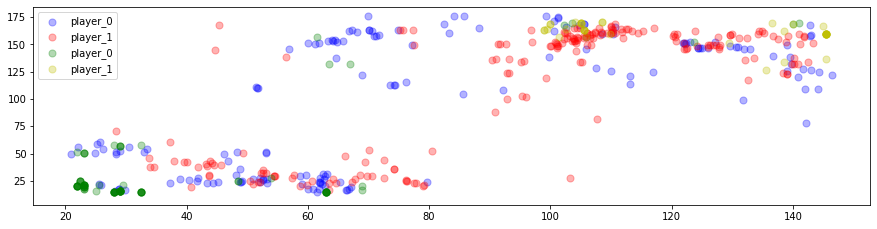

Total game time: 9.58
Winner: Player_0
Player_0: P
Player_1: Z


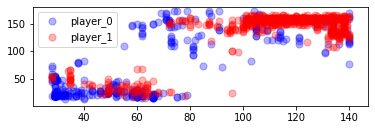

Total game time: 9.58
Winner: Player_0
Player_0: P
Player_1: Z


In [0]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plot_rightclick(train2, 888)
plt.subplot(2,1,2)
plot_camera(train2, 888)

In [7]:
import re
df = train2[(train2['event']=='Selection')&(train2['event_contents']!='[]')]["event_contents"]
player_select = [re.sub('\[.*?\]','',item) for item in df.str.strip('[]').str.replace('\'','')]
play , select_list = {}, []
for select0 in player_select:
    sell = select0.replace(' ','').split(',')
    for se in sell:
        try:
            play[se]+=1
        except:
            play[se]=1
            select_list.append(se)
other_list = []
for j,k in enumerate(play.values):
    if k < 10:
        other_list.append(select_list[j])
        select_list[j] = 'Others'
select_list = list(set(select_list))
select_list

TypeError: ignored

In [0]:
def selection_process(df):
    df1 = df.loc[df['event']=='Selection']
    df_result = pd.DataFrame(columns=['game_id'])
    df1_result.game_id = game_ids
    for game_id in tqdm(game_ids):
        df1 = df1.loc[df['game_id']==game_id]
        df_0 = df1.loc[df['player']==0]["event_contents"]
        df_1 = df1.loc[df['player']==1]["event_contents"]
        df_0 = df_0.str.replace('[]','None', regex=False)
        df_1 = df_1.str.replace('[]','None', regex=False)
        player_0_select = [re.sub('\[.*?\]','',item) for item in df_0['event_contents'].str.strip('[]').str.replace('\'','')]
        player_1_select = [re.sub('\[.*?\]','',item) for item in df_1['event_contents'].str.strip('[]').str.replace('\'','')]
        select_list0, select_list1 ,play0, play1 = [],[] , {},{}
        for select0 in player_0_select:
            sell = select0.replace(' ','').split(',')
            for se in sell:
                try: play0[se]+= 1
                except: 
                    play0[se]=1
                    select_list.append(se)            
        for select1 in player_1_select:
            sell = select1.replace(' ','').split(',')
            for se in sell:
                try: play1[se]+= 1
                except: 
                    play1[se]=1
                    select_list1.append(se)
    select_list = set(select_list0) | set(select_list1())
        
    return play0, play1

In [0]:

def selection_process(df, game_id):
  df = df.loc[df['game_id']==game_id]
  df = df.loc[df['event']=='Selection']
  df_0 = df.loc[df['player']==0]
  df_1 = df.loc[df['player']==1]
  # (r'\([^)]*\)
  df_0["event_contents"] = df_0['event_contents'].str.replace('[]','None', regex=False)
  df_1["event_contents"] = df_1['event_contents'].str.replace('[]','None', regex=False)
  player_0_select = [re.sub('\[.*?\]','',item) for item in df_0['event_contents'].str.strip('[]')]
  # player_0_select = player_0_select.str.replace('[[^\w\s]]','')
  player_1_select = [re.sub('\[[^)]*\]' ,'', item) for item in df_1['event_contents'].str.strip('[]')]
  # player_1_select = [item for item in pd.Series(player_1_select).str.split(' ')]

  return player_0_select

In [0]:
def ability_process(df):
  df = df[(df['event']=='Ability')&(df['event_contents'].notnull())][["game_id","player","event_contents"]]
  df["player_ability_code"] = [item for item in df["event_contents"].str.split(' ',expand=True).iloc[:,2].str.slice(0,4)]
  df["player_ability_code"][df["player_ability_code"].isnull()] = "Other"
  df_g = df.groupby('player_ability_code')["game_id"].count()
  df_g_down = df_g[df_g<1000].index
  df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down))] = "Other"

  df_g = df.groupby(['game_id','player','player_ability_code']).count().unstack()
  df_g.columns = df_g.columns.droplevel(0)
  df_g_col = list(df_g.columns)
  df_g = df_g.reset_index().fillna(0)
  return df_g, df_g_col, df_g_down

In [0]:

df_g,df_g_col, df_g_down = ability_process(train2)
list1 = ['game_id']
player_ab0 = df_g[df_g['player']==0][list1+df_g_col]
player_ab0.columns = list1 + [item+"_0" for item in df_g_col]
player_ab1 = df_g[df_g['player']==1][list1+df_g_col]
player_ab1.columns = list1 + [item+"_1" for item in df_g_col]
df_train = df_train.merge(player_ab0, on="game_id",how="left")
df_train = df_train.merge(player_ab1, on="game_id",how="left")
df_train = df_train.fillna(0)
for col in df_g_col:
  df_train[col+"_diff"] = df_train[col+"_0"] - df_train[col+"_1"]
  df_train.drop([col+"_0",col+"_1"],axis=1, inplace=True)

In [0]:
df_train.head()

In [17]:
train2[(train2['event']=='Ability')&(train2['game_id']==3)].head(50)

,game_id,winner,time,player,species,event,event_contents
5799,3,0,0.01,0,T,Ability,(1360) - TrainSCV
5801,3,0,0.01,1,P,Ability,(15E0) - TrainProbe
5913,3,0,0.24,0,T,Ability,"(1021) - BuildSupplyDepot; Location: (115.0, 4..."
5937,3,0,0.30,0,T,Ability,(1360) - TrainSCV
5938,3,0,0.30,1,P,Ability,(15E0) - TrainProbe
5960,3,0,0.36,1,P,Ability,(F00) - Gather; Target: DestructibleSignsConst...
5978,3,0,0.41,1,P,Ability,(15E0) - TrainProbe
6041,3,0,0.54,1,P,Ability,"(1543) - BuildGateway; Location: (25.5, 133.5,..."
6045,3,0,0.56,0,T,Ability,"(1023) - BuildBarracks; Location: (113.5, 43.5..."
6066,3,0,1.00,1,P,Ability,(1542) - BuildAssimilator; Target: Destructibl...


In [0]:
train1 = train[(train["time"]>2.0)&(train["time"]<3.0)][["player","winner","event","time"]]
train1['win'] = (train1['winner'] == train1['player'])
train1["count"] = 1
train1_g = train1[["win","event","count"]].groupby(["event","win"]).sum().reset_index()
train1_g

,event,win,count
0,Ability,False,171360
1,Ability,True,177577
2,AddToControlGroup,False,7182
3,AddToControlGroup,True,8061
4,Camera,False,1861486
5,Camera,True,1842188
6,ControlGroup,False,1340
7,ControlGroup,True,1551
8,GetControlGroup,False,703777
9,GetControlGroup,True,842746


In [0]:

# train2 = train[train["event"]=="Right Click"][["game_id","event_contents"]]
#  np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in train2['event_contents']])

array(['(1021) - BuildSupplyDepot; Location: (135.0, 42.0, 49119)'],
      dtype=object)

In [0]:
train2[train2["event"]=="Selection"].tail()

,game_id,winner,time,player,species,event,event_contents
67091719,38871,0,8.43,0,Z,Selection,['Egg [5700004]']
67091720,38871,0,8.43,0,Z,Selection,['Egg [5700004]']
67091723,38871,0,8.43,0,Z,Selection,['Drone [4300006]']
67091748,38871,0,8.49,0,Z,Selection,['Egg [47C0004]']
67091750,38871,0,8.49,0,Z,Selection,['Egg [47C0004]']


In [0]:
def plot_category_hist(data, category,tar):
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    sns.distplot(data[(data[category] == tar)&(data["win"]==False)]["count"])
    plt.subplot(2,1,2)
    sns.distplot(data[(data[category] == tar)&(data["win"]==True)]["count"])
    plt.legend(data[category].unique())

In [0]:
event_right = train[train.event=="Right Click"][["game_id","event_contents","player"]].reset_index(drop=True)
event_right["event_target"] = ""
event_right["event_target"] = event_right["event_contents"][event_right["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target"].str.split(':',expand=True).iloc[:,2]
event_right.dropna(axis=0,inplace=True)
event_right.drop("event_contents",axis=1,inplace=True)
event_right

,game_id,player,event_target
7,0,0,"(150.0, 22.5, 49120)"
8,0,1,"(27.5, 154.5, 49120)"
10,0,0,"(140.0, 47.0, 40928)"
12,0,0,"(154.0, 55.5, 40928)"
15,0,1,"(18.0, 147.5, 49120)"
...,...,...,...
11565870,38871,0,"(168.5, 24.5, 49088)"
11565871,38871,0,"(168.5, 24.5, 49088)"
11565872,38871,0,"(168.5, 24.5, 49088)"
11565873,38871,0,"(168.5, 24.5, 49088)"


In [0]:
event_right1.str.split(' ',expand=True).iloc[:,1].value_counts()[:15]

DestructibleSignsConstruction    828419
None                             627809
Assimilator                      129630
Refinery                         125320
Extractor                        121819
DestructibleSignsFunny            82821
Hatchery                          57955
SCV                               57348
Probe                             37647
Drone                             37030
Nexus                             35184
Medivac                           31579
OrbitalCommand                    31076
Bunker                            26967
Pylon                             25948
Name: 1, dtype: int64

In [0]:
# df_0 = event_right.loc[(event_right['player']==0)&(event_right['game_id']==10000)]
# df_1 = event_right.loc[(event_right['player']==1)&(event_right['game_id']==10000)]
df_0 = event_right.loc[(event_right['player']==0)]
df_1 = event_right.loc[(event_right['player']==1)]
right_plot_0 = np.array([item.replace('(', '').replace(')', '').split(',') for item in df_0["event_target"]]).astype(float)
right_plot_1 = np.array([item.replace('(', '').replace(')', '').split(',') for item in df_1["event_target"]]).astype(float)

# plt.scatter(right_plot_0[:, 0], right_plot_0[:, 1], label='player_0', alpha=0.3, color='b', s=50)
# plt.scatter(right_plot_1[:, 0], right_plot_1[:, 1], label='player_1', alpha=0.3, color='r', s=50)
# plt.legend()

(array([ 24067.,   2266., 425694.,   4822.,   5412., 852866.,   2083.,
         12769.,   3168.,  11963.]),
 array([30720. , 34302.4, 37884.8, 41467.2, 45049.6, 48632. , 52214.4,
        55796.8, 59379.2, 62961.6, 66544. ]),
 <a list of 10 Patch objects>)

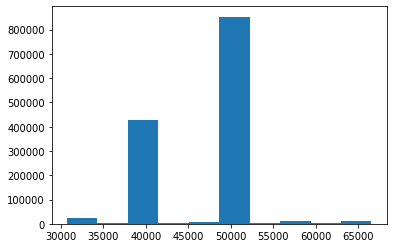

In [0]:
plt.hist(right_plot_0[:, 2])

(array([ 23513.,   1523., 423100.,   6389.,   4187., 842290.,   1869.,
         12493.,   2870.,  13370.]),
 array([30720. , 34204.4, 37688.8, 41173.2, 44657.6, 48142. , 51626.4,
        55110.8, 58595.2, 62079.6, 65564. ]),
 <a list of 10 Patch objects>)

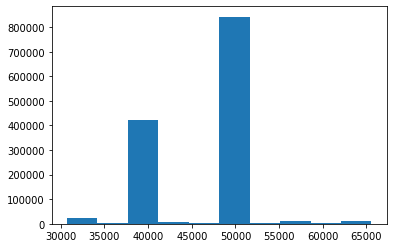

In [0]:
plt.hist(right_plot_1[:, 2])

In [0]:
event_ability = train[train.event=="Ability"][["game_id","event_contents","player"]].reset_index(drop=True)
event_ability["event_target"] = ""
event_ability["event_target"]  = event_ability["event_contents"].str.split(' ',expand=True).iloc[:,2]
# event_right["event_target"] = event_right["event_contents"][event_right["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target"].str.split(':',expand=True).iloc[:,2]
# event_right.dropna(axis=0,inplace=True)
# event_right.drop("event_contents",axis=1,inplace=True)
event_ability["event_target"].value_counts()

Attack;                 568964
TrainSCV                350376
MorphDrone              287254
TrainProbe              258765
TrainMarine             134801
                         ...  
HallucinateWarpPrism         1
CancelUpgradeToHive          1
ThorNormalMode               1
SpawnInfestedTerran;         1
UpgradeShipWeapons2          1
Name: event_target, Length: 355, dtype: int64

In [0]:
event_ability["event_target"].value_counts()[:20]

Attack;                    568964
TrainSCV                   350376
MorphDrone                 287254
TrainProbe                 258765
TrainMarine                134801
SpawnLarva;                130289
BuildSupplyDepot;          101042
BuildPylon;                 92507
MorphOverlord               90700
MorphZergling               83416
CalldownMULE;               67843
BuildRefinery;              51370
TrainQueen                  51130
BuildExtractor;             47697
BuildBarracks;              47546
BuildGateway;               46414
BuildAssimilator;           43208
LowerSupplyDepot            42761
CancelLast                  35684
UpgradeToOrbitalCommand     34531
Name: event_target, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_y = df_train["winner"]
train_x = df_train.drop(["winner",'game_id'],axis=1)
scaler = StandardScaler()
train_sc = scaler.fit_transform(train_x)
x_train, x_val , y_train, y_val = train_test_split(train_sc,train_y,test_size=0.1,shuffle=True)

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest_clf = RandomForestClassifier(n_estimators=700, max_depth=25,min_samples_leaf=3,n_jobs=-1)
forest_scores = cross_val_score(forest_clf, train_sc, train_y, cv=5,verbose=100)
forest_scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] .................................... , score=0.604, total=   3.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.614, total=   3.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.628, total=   3.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.609, total=   3.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.1s remaining:    0.0s
[CV]  .........................

0.6145814633161738

In [205]:
from sklearn.metrics import f1_score
forest_clf.fit(x_train,y_train)
y_pred = forest_clf.predict(x_val)
f1_score(y_val,y_pred)

0.614482406935237

In [0]:
df_test = pd.DataFrame(columns=['game_id'])
df_test.game_id = test.game_id.unique()
df_test['time'] = np.array(test[test.shift(-1).game_id != test.game_id].time)
df_test["win_prop"] = 0.5

df = test[['game_id', 'player', 'species']]
df = df.drop_duplicates().reset_index(drop=True)

for game_id in df_test.game_id:
  player0_sp = df[df['game_id']==game_id]['species'].iloc[0]
  player1_sp = df[df['game_id']==game_id]['species'].iloc[1]
  if (player0_sp == player1_sp):
    continue
  elif (player0_sp == 'T') and (player1_sp == 'P'):
    df_test["win_prop"][game_id] = game['PvT']/(game['TvP']+game['PvT'])
  elif (player0_sp == 'T') and (player1_sp == 'Z'):
    df_test["win_prop"][game_id] = game['ZvT']/(game['TvZ']+game['ZvT'])
        
  elif (player0_sp == 'P') and (player1_sp == 'T'):
    df_test["win_prop"][game_id] = game['TvP']/(game['TvP']+game['PvT'])
  elif (player0_sp == 'P') and (player1_sp == 'Z'):
    df_test["win_prop"][game_id] = game['ZvP']/(game['PvZ']+game['ZvP'])
        
  elif (player0_sp == 'Z') and (player1_sp == 'T'):
    df_test["win_prop"][game_id] = game['TvZ']/(game['TvZ']+game['ZvT'])
  elif (player0_sp == 'Z') and (player1_sp == 'P'):
    df_test["win_prop"][game_id] = game['PvZ']/(game['PvZ']+game['ZvP'])

In [0]:
for event in train.event.unique():
    df = test[(test.player==0)&(test.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_0'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_test = pd.merge(df_test, df, on='game_id', how='left')

    df = test[(test.player==1)&(test.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_1'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_test = pd.merge(df_test, df, on='game_id', how='left')
    
df_test = df_test.fillna(0)
for event in train.event.unique():
    df_test[event + '_diff'] = df_test[event+'_count_0'] - df_test[event+'_count_1']
    df_test.drop([event+'_count_0',event+'_count_1'],axis=1,inplace=True)

In [0]:
df_test.head()

In [229]:
test2 = test.dropna(axis=0)
df = test2[(test2['event']=='Ability')&(test2['event_contents'].notnull())][["game_id","player","event_contents"]]
df["player_ability_code"] = [item for item in df["event_contents"].str.split(' ',expand=True).iloc[:,2].str.slice(0,4)]
df["player_ability_code"][df["player_ability_code"].isnull()] = "Other"
df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down))] = "Other"
df_g = df.groupby('player_ability_code').count()
df_g_down1 = df_g[df_g<50].index
df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down1))] = "Other"
df_g = df.groupby(['game_id','player','player_ability_code']).count().unstack()

df_g.columns = df_g.columns.droplevel(0)
df_g_col = list(df_g.columns)
df_g = df_g.reset_index().fillna(0)
list1 = ['game_id']

player_ab0 = df_g[df_g['player']==0][list1+df_g_col]
player_ab0.columns = list1 + [item+"_0" for item in df_g_col]
player_ab1 = df_g[df_g['player']==1][list1+df_g_col]
player_ab1.columns = list1 + [item+"_1" for item in df_g_col]
df_test = df_test.merge(player_ab0, on="game_id",how="left")
df_test = df_test.merge(player_ab1, on="game_id",how="left")
df_test = df_test.fillna(0)
for col in df_g_col:
  df_test[col+"_diff"] = df_test[col+"_0"] - df_test[col+"_1"]
  df_test.drop([col+"_0",col+"_1"],axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [230]:
df_test.shape

(16787, 12)

In [225]:
df_train.shape

(38872, 62)

In [231]:
df_g_down

Index(['Adep', 'Atta', 'Batt', 'Buil', 'Burr', 'Call', 'Canc', 'Chro', 'Cloa',
       'Cree', 'Evol', 'Extr', 'Fung', 'Gath', 'Hold', 'KD8C', 'Land', 'Libe',
       'Lift', 'Lock', 'Lowe', 'Lurk', 'Medi', 'Morp', 'Moth', 'Orac', 'Other',
       'Patr', 'Phas', 'Quee', 'Rais', 'Rava', 'Rese', 'Retu', 'Root', 'SCVR',
       'Scan', 'SetR', 'SetU', 'SetW', 'Sieg', 'Spaw', 'Stop', 'Tank', 'Trai',
       'Tran', 'Unbu', 'Unlo', 'Upgr', 'Upro', 'UseS', 'Warp'],
      dtype='object', name='player_ability_code')